In [ ]:
#Loading the Drive helper and mount
from google.colab import drive
#HERE Will prompt for authorisation
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
import seaborn as sns
import plotly.graph_objs as go

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests

import statsmodels.api as sm



from scipy.stats import pearsonr
from pylab import rcParams

mpl.rcParams['figure.figsize']= (10,8)
mpl.rcParams['axes.grid']= False

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = '/content/drive/My Drive/Energy project/dataset.csv'
df = pd.read_csv(path, index_col=0, parse_dates=True)
df.head(10)

,phasor_diff1,PV_hoch
time,,
2020-02-01 00:00:00,0.175611,0.0
2020-02-01 00:15:00,0.191028,0.0
2020-02-01 00:30:00,0.185786,0.0
2020-02-01 00:45:00,0.197130,0.0
2020-02-01 01:00:00,0.171353,0.0
2020-02-01 01:15:00,0.203891,0.0
2020-02-01 01:30:00,0.187335,0.0
2020-02-01 01:45:00,0.205745,0.0
2020-02-01 02:00:00,0.208079,0.0


#### p-value:
#### The p value is the evidence against a null hypothesis. The smaller the p-value, the stronger the evidence that you should reject the null hypothesis.

### KPSS test
##### H0: Null hypothesis - data is stationary
##### H1: Alternate hypothesis - data is not stationary
##### t-statistic more extreme than critical value, reject null hypothesis
##### p-value less than 0.05, reject null hypothesis

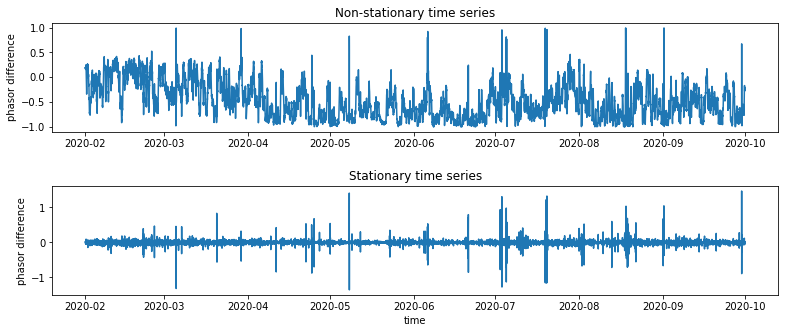

In [ ]:
rcParams['figure.figsize'] = 13, 5

fig, ax = plt.subplots(2)

ax[0].plot(df['phasor_diff1'])
#plt.ylabel('phasor difference', fontsize=10)
#plt.xlabel('time',fontsize=12)
ax[0].set(title='Non-stationary time series', ylabel='phasor difference')
plt.subplots_adjust(hspace=.5,wspace=0.4)
#plt.show()
#final_df['phasor_diff1'].plot()

df_diff = df.diff(periods=1)
df_diff.dropna(inplace=True)
#df_diff.head()

#df_diff['phasor_diff1'].plot()
ax[1].plot(df_diff['phasor_diff1'])

ax[1].set(title='Stationary time series', ylabel='phasor difference', xlabel='time')
#plt.xlabel(fontsize=12)
#plt.title('non-stationary time series')
plt.show()

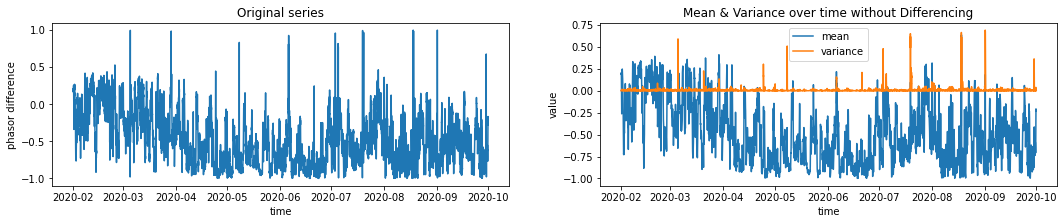

In [ ]:
rcParams['figure.figsize'] = 18, 3

mean_var_df = df.copy()
mean_var_df['mean'] = mean_var_df['phasor_diff1'].rolling(window=12).mean()
mean_var_df['variance'] = mean_var_df['phasor_diff1'].rolling(window=12).var()

fig, ax = plt.subplots(1,2)

ax[0].plot(mean_var_df['phasor_diff1'])
ax[0].set(title='Original series', ylabel='phasor difference', xlabel='time')


ax[1].plot(mean_var_df[['mean','variance']])
ax[1].set(title='Mean & Variance over time without Differencing', ylabel='value', xlabel='time')
ax[1].legend(['mean', 'variance'])

#plt.subplots_adjust(hspace=.5,wspace=0.4)
#plt.ticklabel_format(style = 'plain')

#plt.xlabel('time', family='Arial', fontsize=10)
#plt.ylabel('value', family='Arial', fontsize=10)
#plt.ylabel('Phasor Difference', family='Arial', fontsize=10)
#plt.xticks(rotation=45, fontsize=8)
plt.show()

#### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
##### The pattern of the correlation for different lags is obvious when it decreases exponentially, and depending on whether the values of lag is positive and negative it will alternate between positive and negative values.

### PACF

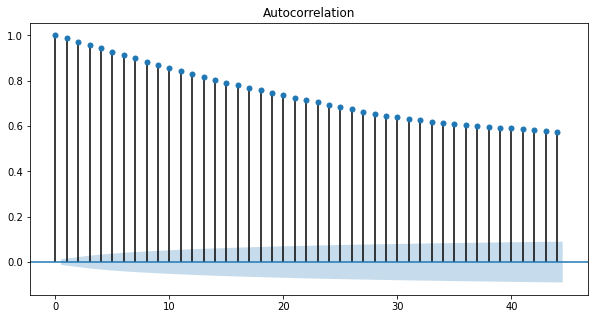

In [ ]:
rcParams['figure.figsize'] = 10, 5
plot_acf(df['phasor_diff1'])
plt.show()

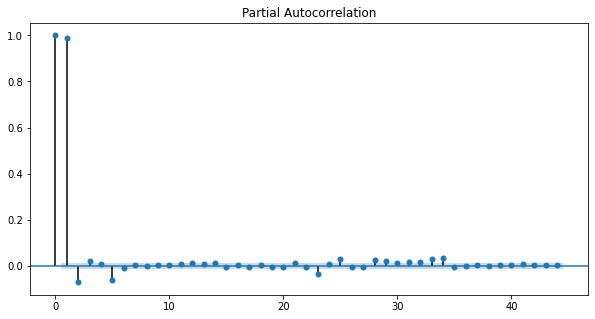

In [ ]:
rcParams['figure.figsize'] = 10, 5
plot_pacf(df['phasor_diff1'])
plt.show()

### KPSS Test
##### H0: Null Hypothesis - series is stationary
##### H1: Alternate Hypothesis - series is not stationary
##### If p-value <= 0.05, reject null hypothesis
##### If Test-Statistic is more extreme than critical value, reject null hypothesis

##### The null hypothesis for the KPSS test is that the data are stationary.
##### For this test, we do NOT want to reject the null hypothesis. In other words, we want the p-value to be greater than 0.05 not less than 0.05.

In [ ]:
for i in range(len(df.columns)):
  result = kpss(df[df.columns[i]], 'ct', lags='auto')

  if result[1] > 0.05:
    print("KPSS Test on", '{}'.format(df.columns[i]),"\n ", '-'*47)
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical values: {result[3]}')
    print(f'Lags: {result[2]}')
    print('{} - series is stationary'.format(df.columns[i]))  # accept null hypothesis
  else:
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical values: {result[3]}')
    print(f'Lags: {result[2]}') 
    print('{} - series is not stationary'.format(df.columns[i])) # reject null hypothesis

Test Statistics: 2.131412368735222
p-value: 0.01
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Lags: 90
phasor_diff1 - series is not stationary
Test Statistics: 2.5627669880202784
p-value: 0.01
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Lags: 89
PV_hoch - series is not stationary


##### => p-value is < 0.05, reject H0:series is stationary.
##### => 5% critical value is less than Test Statistic, we should reject H0.

### Granger Causality Test
##### The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another. If the probability value is less than any α level, then the hypothesis would be rejected at that level.
##### H0: Xt does NOT granger cause Yt
##### H1: Xt does granger cause Yt

In [ ]:
max_lags = 8
y = 'phasor_diff1'


for i in range(len(df.columns)-1):
  results = grangercausalitytests(df[[y, df.columns[i+1]]], max_lags, verbose=False)
  p_values = [round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
  print('Column - {}: P-Values - {}'.format(df.columns[i+1], p_values))

Column - PV_hoch: P-Values - [0.5641, 0.1068, 0.0003, 0.0, 0.0, 0.0, 0.0, 0.0]


##### => p-value is larger than 0.05 for lag 1 & 2, H0 should not be rejected. Therefore, PV infeed does NOT granger cause phasor difference. 

##### => However, p-value is less than 0.05 from lag 3. Thefore, PV infeed does granger cause phasor difference at lag 3.

#### Notes:
##### If the p-value for this test is less than the designed value of α, then we reject the null hypothesis and conclude that x causes y (at least in the Granger causality sense). Observation: The Granger Causality test assumes that both the x and y time series are stationary.

#### Correlation

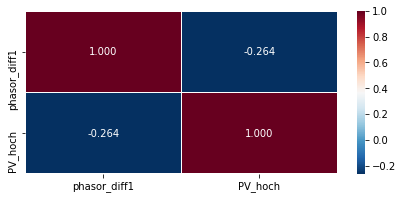

In [ ]:
mpl.rcParams['figure.figsize']= 7,3
pearsoncorr = df.corr(method='pearson')
sns.heatmap(pearsoncorr,
xticklabels=pearsoncorr.columns,
yticklabels=pearsoncorr.columns, 
cmap='RdBu_r', annot=True, fmt='.3f',linewidth=0.5)
plt.show()

#### First Difference
###### Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

In [ ]:
df_diff = df.diff(periods=1)
df_diff.dropna(inplace=True)
#df_diff.head()

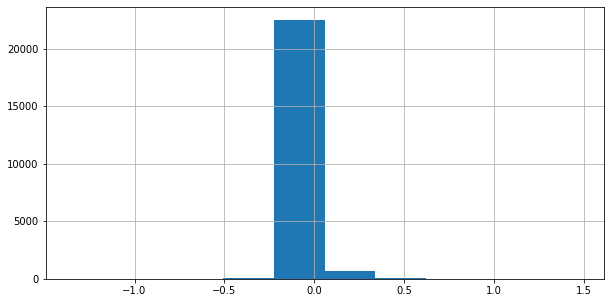

In [ ]:
rcParams['figure.figsize'] = 10, 5
df_diff['phasor_diff1'].hist()

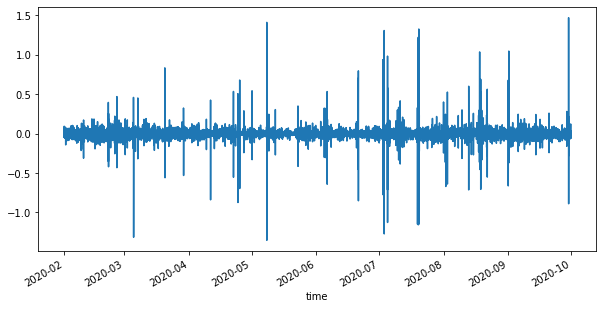

In [ ]:
rcParams['figure.figsize'] = 10, 5
df_diff['phasor_diff1'].plot()
#final_df['phasor_diff1'].plot()
plt.show()

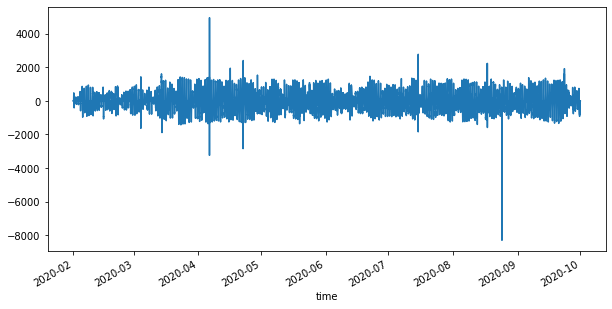

In [ ]:
rcParams['figure.figsize'] = 10, 5
df_diff['PV_hoch'].plot()
plt.show()

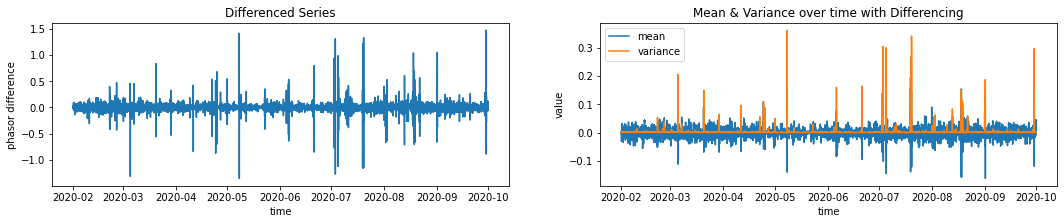

In [ ]:
rcParams['figure.figsize'] = 18, 3

mean_var_df = df_diff.copy()
mean_var_df['mean'] = mean_var_df['phasor_diff1'].rolling(window=12).mean()
mean_var_df['variance'] = mean_var_df['phasor_diff1'].rolling(window=12).var()

fig, ax = plt.subplots(1,2)

ax[0].plot(mean_var_df['phasor_diff1'])
ax[0].set(title='Differenced Series', ylabel='phasor difference', xlabel='time')


ax[1].plot(mean_var_df[['mean','variance']])
ax[1].set(title='Mean & Variance over time with Differencing', ylabel='value', xlabel='time')
ax[1].legend(['mean', 'variance'])
#plt.subplots_adjust(hspace=.5,wspace=0.4)
#plt.ticklabel_format(style = 'plain')

#plt.xlabel('time', family='Arial', fontsize=10)
#plt.ylabel('value', family='Arial', fontsize=10)
#plt.ylabel('Phasor Difference', family='Arial', fontsize=10)
#plt.xticks(rotation=45, fontsize=8)
plt.show()

#### Check for stationary after differencing with KPSS test

In [ ]:
for i in range(len(df_diff.columns)):
  result = kpss(df_diff[df_diff.columns[i]], 'ct', lags='auto')

  if result[1] > 0.05:
    print("KPSS Test on", '{}'.format(df_diff.columns[i]),"\n ", '-'*47)
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical values: {result[3]}')
    print(f'Lags: {result[2]}')
    print('{} - series is stationary'.format(df_diff.columns[i]))  # accept null hypothesis
  else:
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical values: {result[3]}')
    print(f'Lags: {result[2]}') 
    print('{} - series is not stationary'.format(df_diff.columns[i])) # reject null hypothesis

KPSS Test on phasor_diff1 
  -----------------------------------------------
Test Statistics: 0.001164076141747983
p-value: 0.1
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Lags: 12
phasor_diff1 - series is stationary
KPSS Test on PV_hoch 
  -----------------------------------------------
Test Statistics: 0.006020726700877446
p-value: 0.1
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Lags: 85
PV_hoch - series is stationary


##### t-statitic is not more extreme than critical value, H0 should not be rejected.
##### p-value is greater than 0.05, H0 should not be rejected.

### ACF & PACF on First Difference dataframe

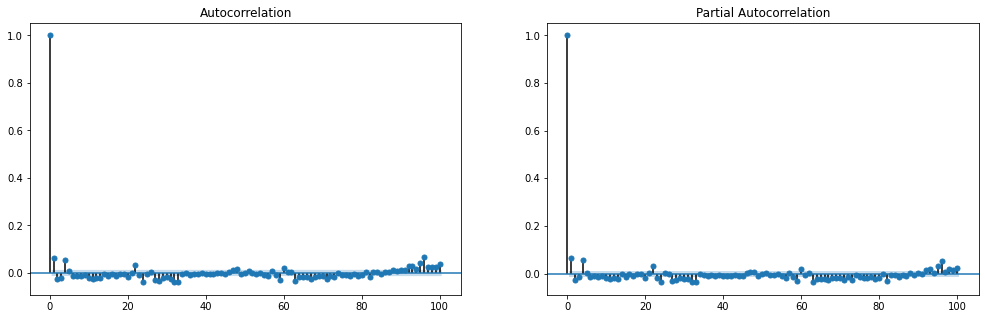

In [ ]:
mpl.rcParams['figure.figsize']= 17,5

fig, (ax1,ax2) = plt.subplots(1,2)

plot_acf(df_diff['phasor_diff1'], ax=ax1, lags=100)

plot_pacf(df_diff['phasor_diff1'], ax=ax2, lags=100)



plt.show()

##### => Exponential decrease of lag
##### => Lag values variation between positive and negative values

#### Therefore, first differenciation should be alright for VAR model.

### Split the dataset for training and testing VAR model

In [ ]:
df_train = df[:int(0.98*(len(df)))]
df_test = df[int(0.98*(len(df))):]
# Check size
print(df_train.shape)
print(df_test.shape)

(22863, 2)
(467, 2)


Text(0, 0.5, 'phasor difference')

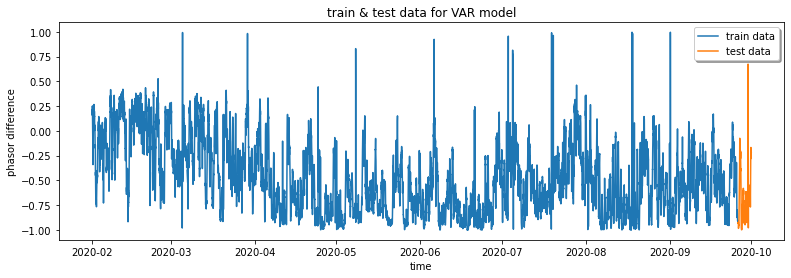

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 4

plt.plot(df_train['phasor_diff1'], label='train data')
plt.plot(df_test['phasor_diff1'], label='test data')

plt.legend(shadow=True)
plt.title('train & test data for VAR model')
plt.xlabel('time')
plt.ylabel('phasor difference')